# 1. 인물모드 직접 해보기

## 1-1. 사진확인

['4.jpg', '2.jpg', '5.jpg', '3.jpg', '6.jpg', '1.jpg', '7.jpg']


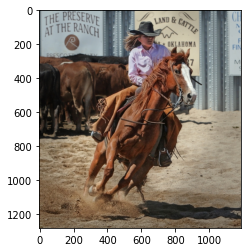

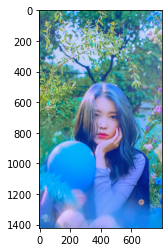

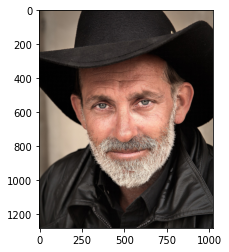

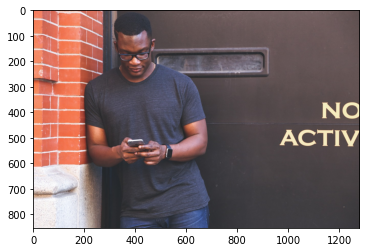

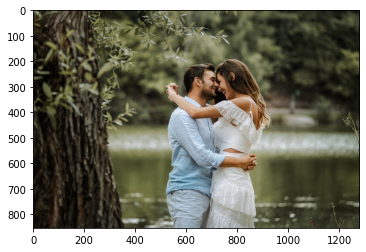

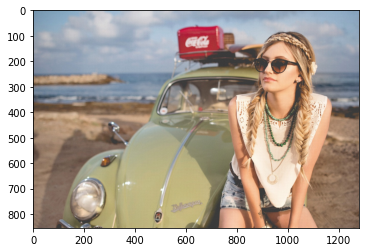

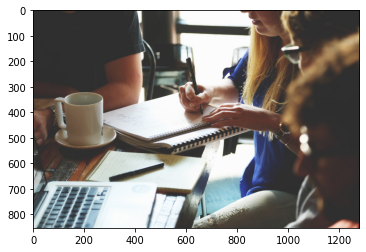

In [1]:
import os
import cv2
from matplotlib import pyplot as plt

# image list
img_path = './data/image'
print(os.listdir(img_path))

for file in os.listdir(img_path):
    if '.ipynb_checkpoints' == file:
        os.rmdir(f'{img_path}/{file}')
    
    plt.imshow(
        cv2.cvtColor(cv2.imread(f'{img_path}/{file}') , cv2.COLOR_BGR2RGB))
    plt.show()

## 1-2. Segmentation 모델 준비

In [2]:
import urllib

model_dir = './data/model'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file)

('./data/model/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0adc61fd60>)

## 1-3. 인물모드 기능 구현

In [3]:
from pixellib.semantic import semantic_segmentation
import numpy as np


def segmentation(path):
    model_dir = './data/model'
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    
    return model.segmentAsPascalvoc(path)
    

def get_segment_map(index, output):
    color_map = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            color_map[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
        
    seg_color = (color_map[index][2], color_map[index][1], color_map[index][0])
    return np.all(output==seg_color, axis=-1)
    
    
def show_portrait_mode(path):
    
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    person_index = LABEL_NAMES.index('person')
    
    segvalues, output = segmentation(path)
    
    if person_index in segvalues['class_ids']:
        seg_map = get_segment_map(person_index, output)
        
        img_orig = cv2.imread(path)
        img_mask = seg_map.astype(np.uint8) * 255
        img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
        img_bg_mask = cv2.bitwise_not(img_mask_color)

        img_orig_blur = cv2.blur(img_orig, (13,13))
        img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
        
        img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show() 
    else:
        print('No Person detected')

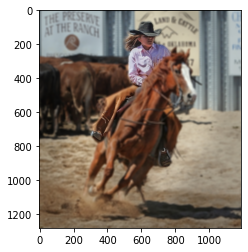

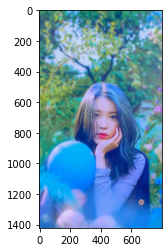

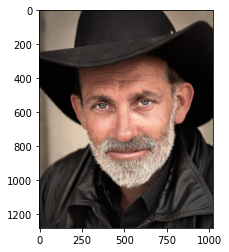

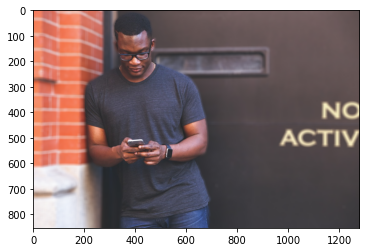

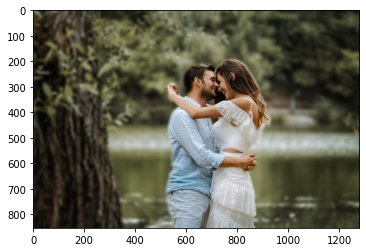

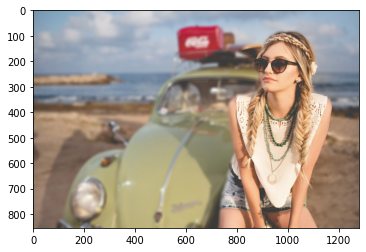

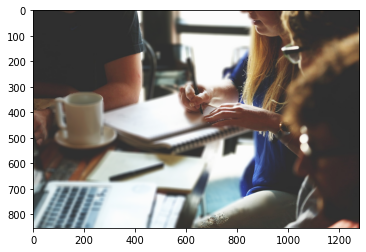

In [4]:
img_path = './data/image'
for file in os.listdir(img_path):
    show_portrait_mode(f'{img_path}/{file}')

# 2. 사진에서 문제점 찾기

> * 해상도가 낮은 사진에서는 배경 블러처리가 잘 안됨
> * 배경이 보이지 않으면 의미가 없어지는듯
> * 나머지는 뭐.. 세그먼테이션 성능을 높이는대로 해결될 이슈같음

# 3. 해결 방법을 제안해 보기

> * sr 모델을 적용해서 배경의 해상도를 높혀준다.